In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import random
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [3]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['paper', '.DS_Store', 'metal', 'cardboard', 'trash', 'glass', 'plastic']

In [4]:
## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices  
import random
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [5]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [6]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/Users/duynguyen/Desktop/BootCamp/projects/Trash/data')

In [7]:
from fastai.vision import get_transforms
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16,num_workers=0)

In [8]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /Users/duynguyen/Desktop/BootCamp/projects/Trash/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /Users/duynguyen/Desktop/BootCamp/projects/Trash/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /Users/duynguyen/Desktop/BootCamp/projects/Trash/data

In [9]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


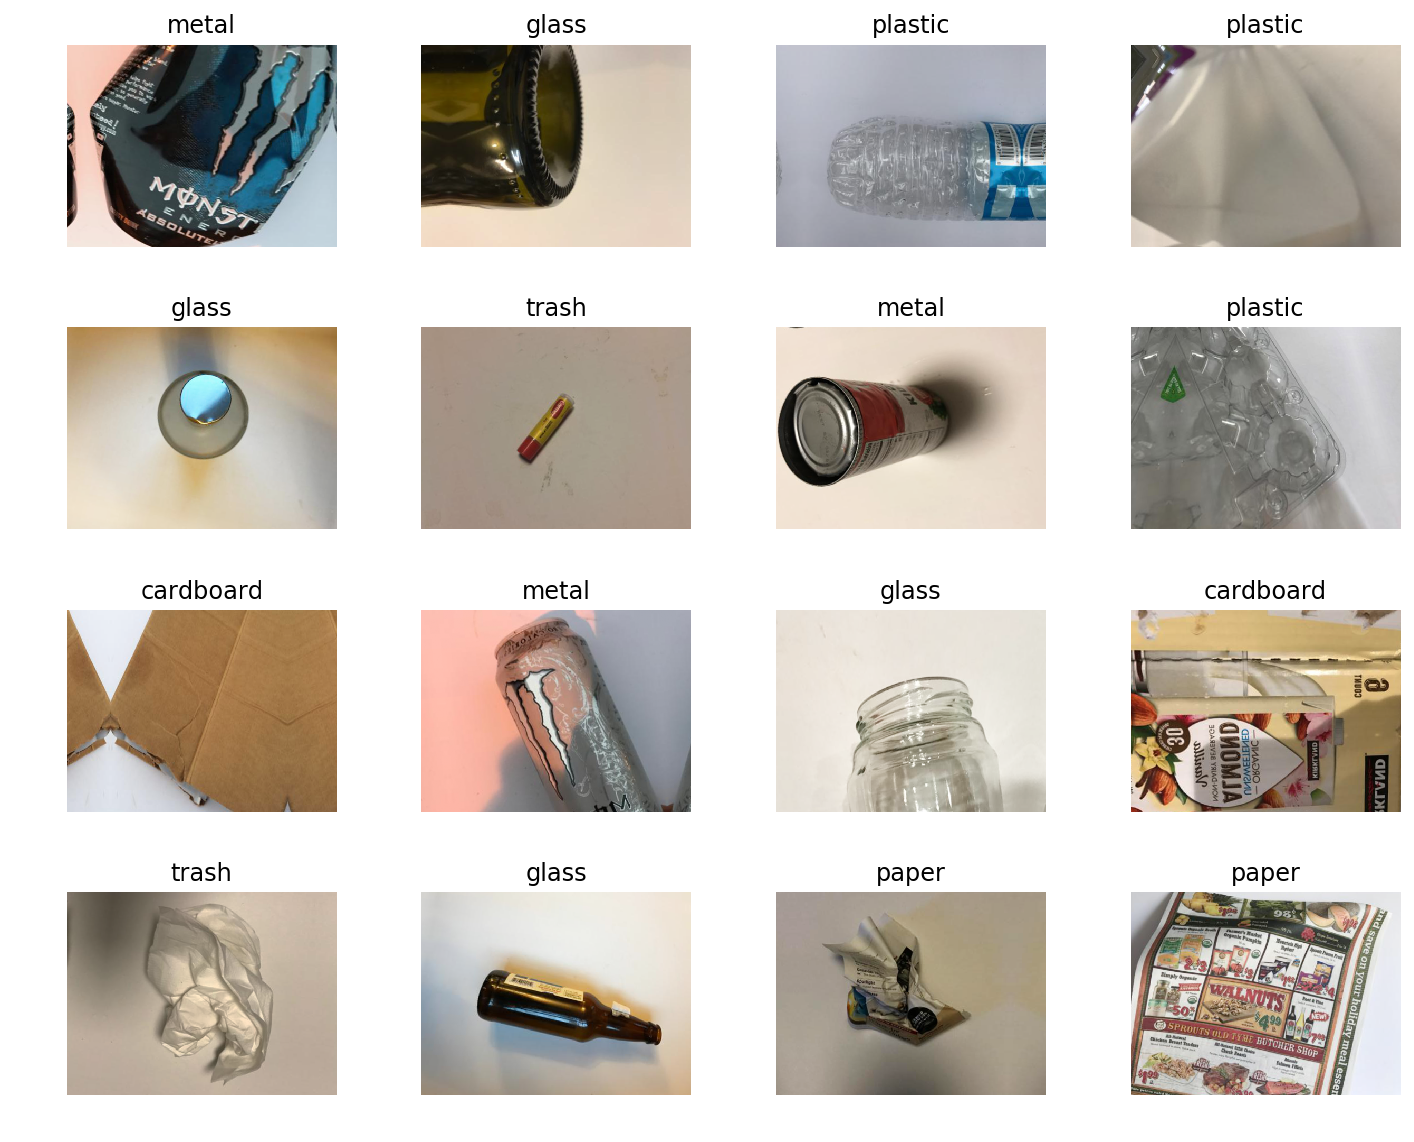

In [10]:
data.show_batch(rows=4,figsize=(10,8))

In [11]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

/anaconda3/envs/PythonData/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [12]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


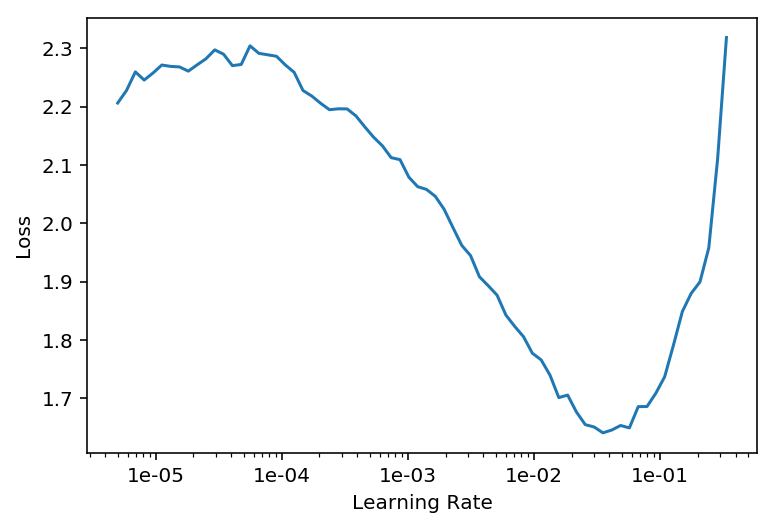

In [13]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(20,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.392270,0.782974,0.263492,27:07
1,0.891293,0.490425,0.177778,26:58
2,0.681599,0.525581,0.193651,28:03
3,0.648961,0.604669,0.203175,28:07
4,0.684038,0.728080,0.228571,28:13
5,0.678999,0.560724,0.193651,27:59
6,0.587458,0.364252,0.131746,28:08
7,0.581434,0.399677,0.149206,28:11
8,0.490545,0.384384,0.117460,28:07
9,0.476614,0.395236,0.136508,28:04


In [15]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

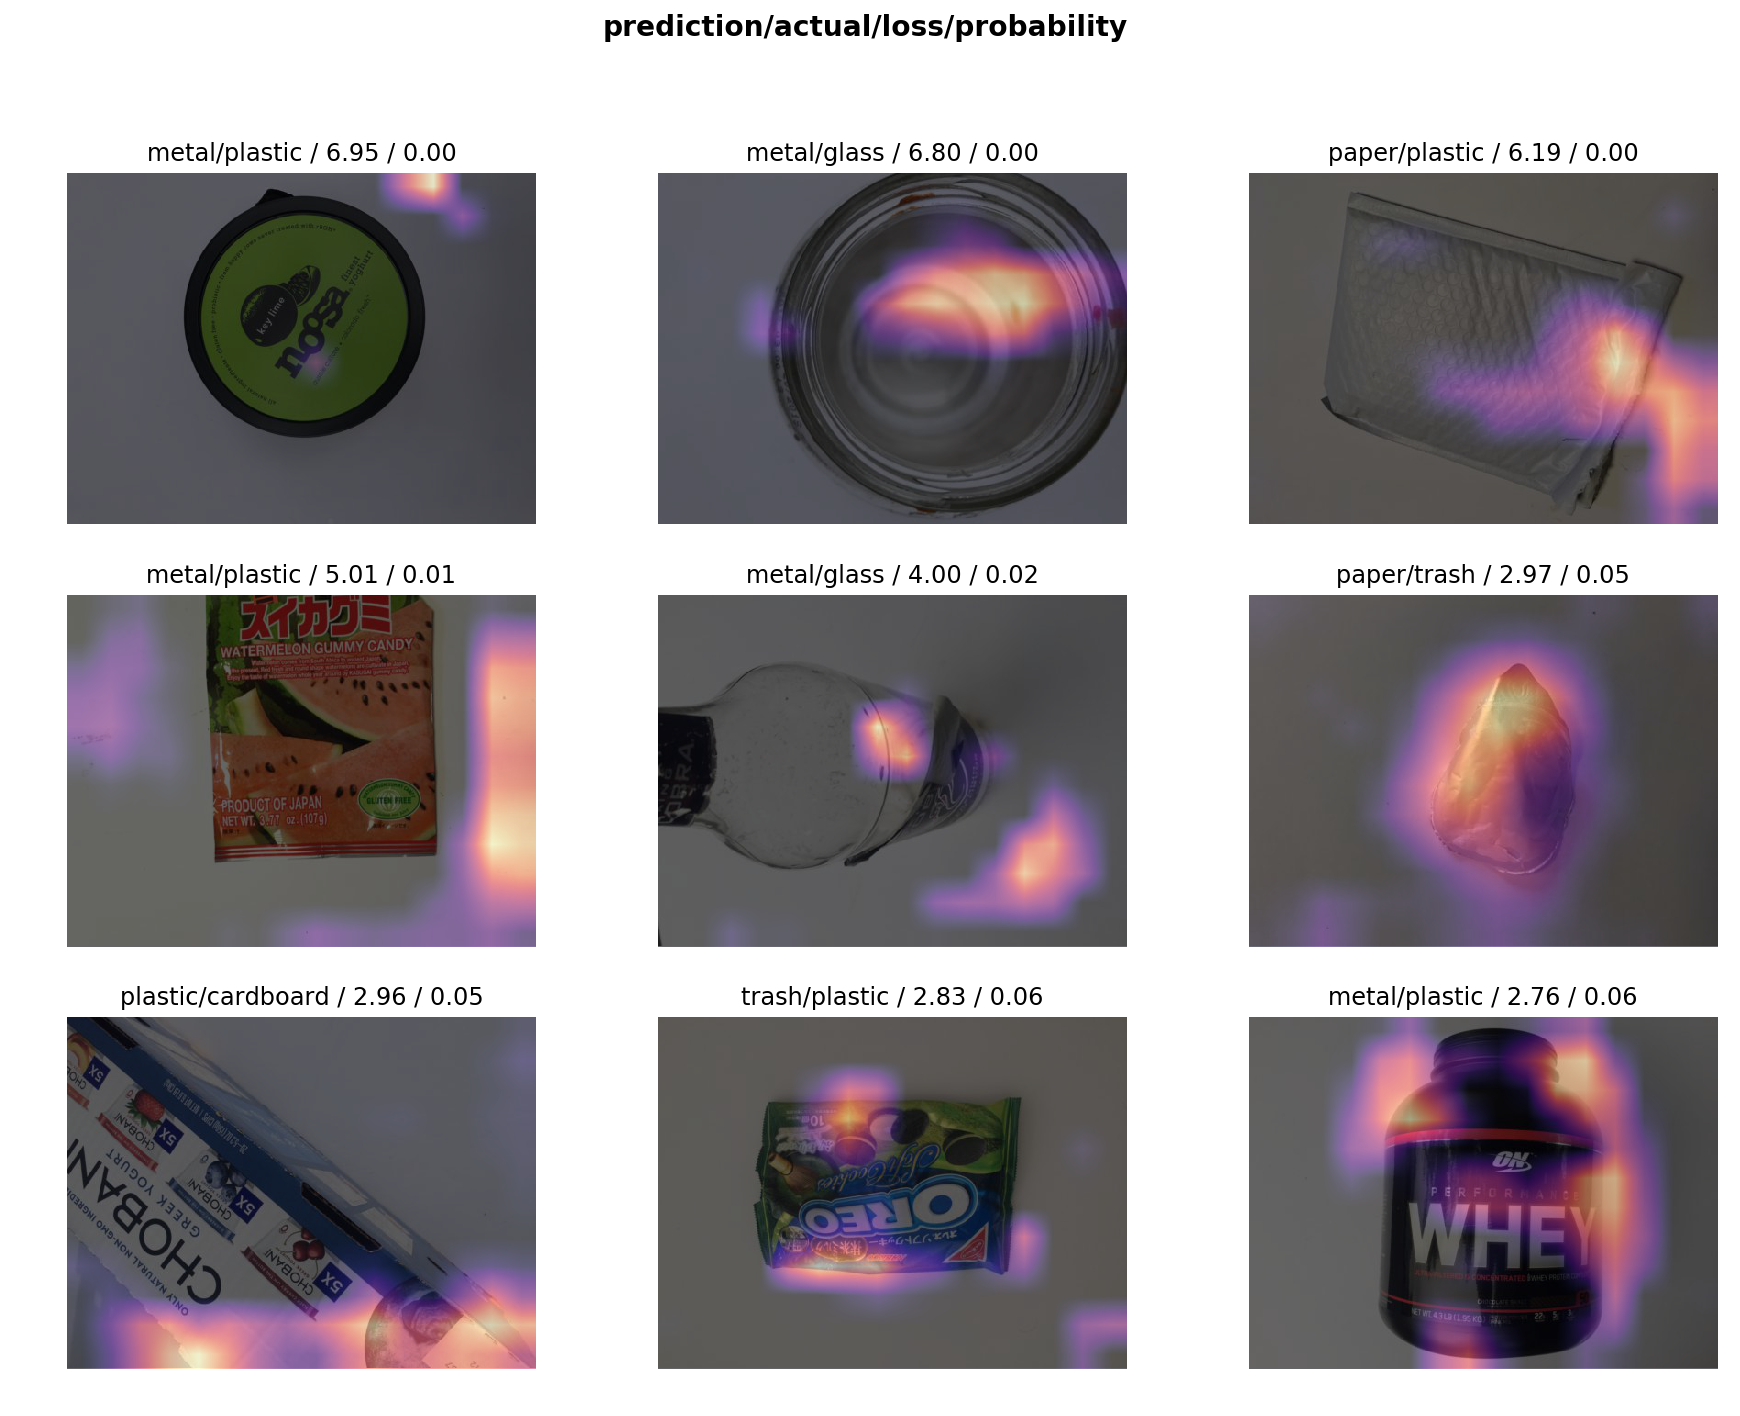

In [16]:
interp.plot_top_losses(9, figsize=(15,11))

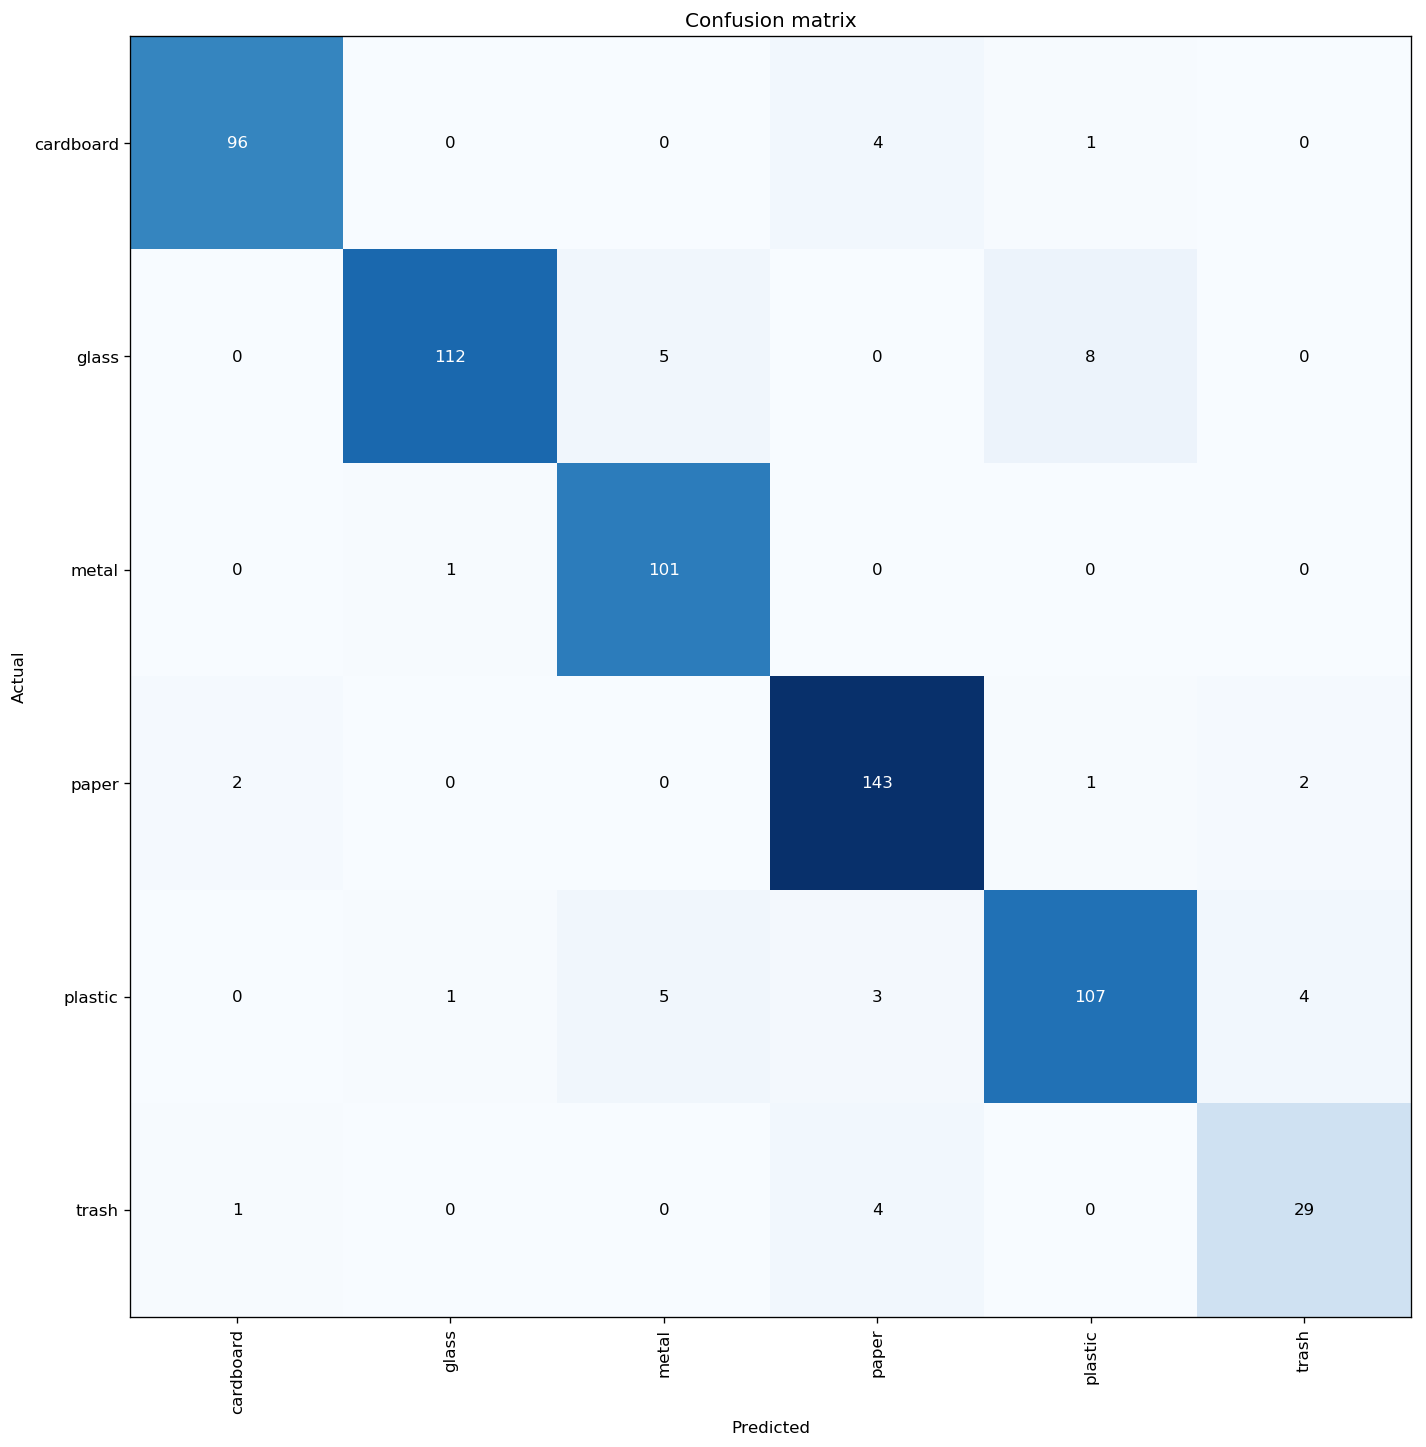

In [17]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [18]:
interp.most_confused(min_val=2)

[('glass', 'plastic', 8),
 ('glass', 'metal', 5),
 ('plastic', 'metal', 5),
 ('cardboard', 'paper', 4),
 ('plastic', 'trash', 4),
 ('trash', 'paper', 4),
 ('plastic', 'paper', 3),
 ('paper', 'cardboard', 2),
 ('paper', 'trash', 2)]

In [19]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [20]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[9.9059e-01, 1.3651e-03, 2.7638e-03, 9.8777e-04, 4.0009e-03, 2.9337e-04],
        [8.1896e-06, 2.0773e-06, 9.9954e-01, 7.4079e-06, 4.3341e-04, 8.3002e-06],
        [1.3867e-06, 2.4320e-04, 1.7867e-05, 1.3950e-07, 9.9974e-01, 1.4678e-06],
        ...,
        [1.5171e-03, 3.0707e-06, 6.8825e-06, 9.9778e-01, 4.5420e-05, 6.4856e-04],
        [4.4078e-04, 7.5072e-06, 7.8263e-06, 9.9571e-01, 3.2286e-04, 3.5140e-03],
        [7.0455e-05, 3.2506e-03, 2.9116e-05, 1.0075e-05, 9.9663e-01, 9.4437e-06]])

In [21]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [66]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))
len(max_idxs)

635

In [23]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [25]:
yhat[:10]

['cardboard',
 'metal',
 'plastic',
 'trash',
 'plastic',
 'trash',
 'glass',
 'paper',
 'paper',
 'cardboard']

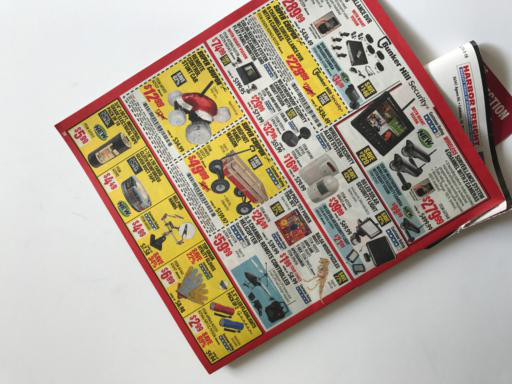

In [50]:
learn.data.test_ds[7][0]

In [27]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [28]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['cardboard', 'metal', 'plastic', 'trash', 'plastic']
['cardboard', 'metal', 'plastic', 'trash', 'plastic']


In [29]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 97   0   2   2   0   0]
 [  0 115   7   0   4   0]
 [  1   5  95   0   0   2]
 [  0   0   1 147   0   1]
 [  0   6   0   1 110   4]
 [  1   1   1   1   1  30]]


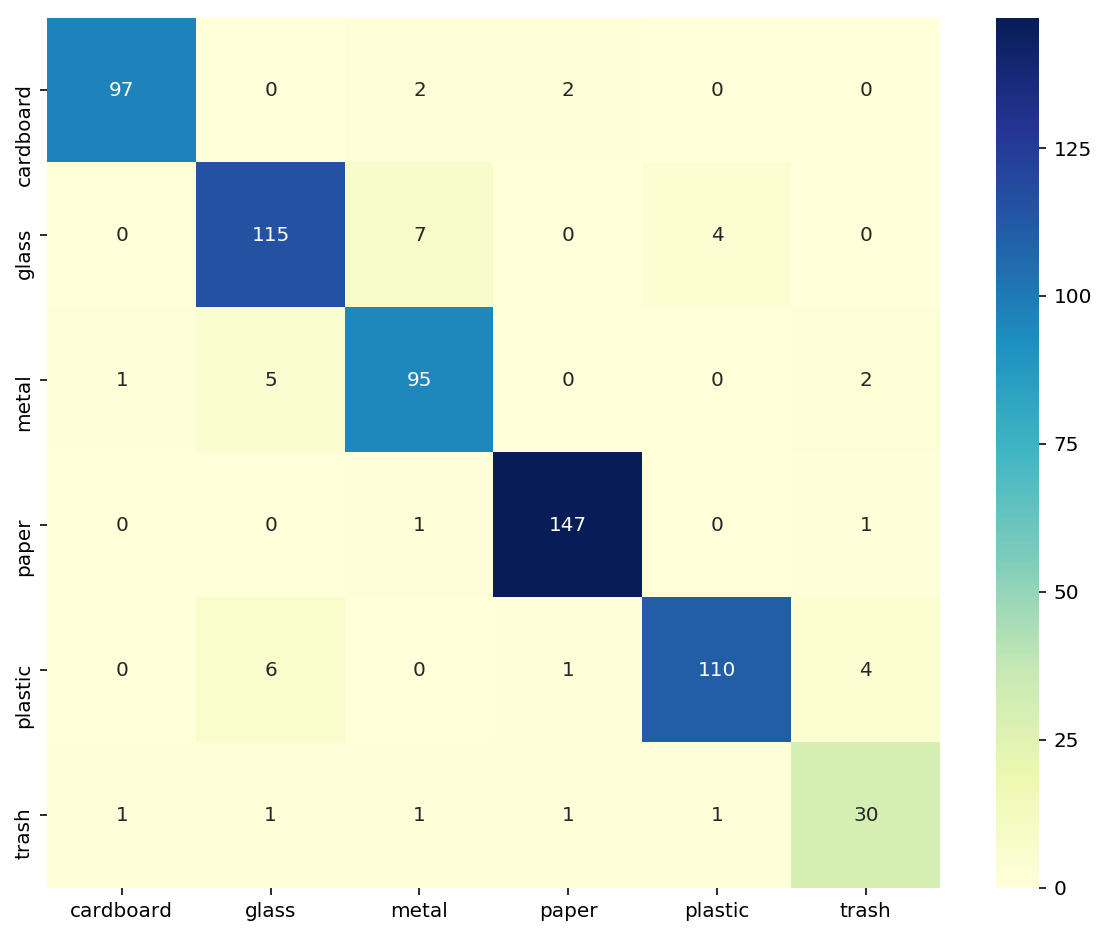

In [30]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [31]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [32]:
accuracy = correct/sum(sum(cm))
accuracy

0.9354330708661417